<a href="https://colab.research.google.com/github/avinashnanda/Fake_news/blob/main/Fake_news_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages and load the data.

In [ ]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from contractions import CONTRACTION_MAP
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import f1_score,precision_score,recall_score
import matplotlib
nltk.download('punkt')
from scipy import sparse
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import unicodedata
plt.rcParams['figure.figsize'] = (10,12 )
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.loc"] = 'best'
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/test.csv")

# Check the dataset size and dependent variable distribution.


*   There is no class imbalance.



In [ ]:
print(train.shape)
print(test.shape)

(20800, 5)
(5200, 4)


In [ ]:
train["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

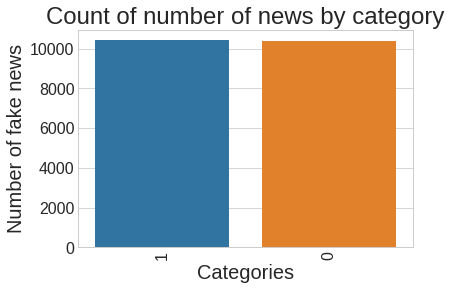

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data = train,x="label",order = train['label'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Categories')
plt.ylabel('Number of fake news')
plt.title('Count of number of news by category')
plt.show()


# Analyzing and imputing NA

* Impute Na with Unknown string

In [ ]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [ ]:
train.fillna('Unknown',inplace=True)
test.fillna('Unknown',inplace=True)

# **Define Helper Functions and Text preprocessing.**


*   Defined my helper functions to do preprocessing like stop word removal,special character removal,lemmatization,word contractions and beautiful confusion matrix.
*   Cleaned the text and appended to the respective dataframe for further processing.

In [ ]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap = sns.color_palette("summer"),cbar=False,linewidths=2, linecolor='black',annot_kws={"size":20})
    plt.savefig(filename)

In [ ]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+')
    return url_pattern.sub(r'', str(text))

In [ ]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[]^_`{|}~'
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [ ]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [ ]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_text(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [ ]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,url_remove =True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True,tokenize=True):
    
    normalized_corpus = []
    tokenized_texts = []
    # normalize each document in the corpus
    for doc in tqdm(corpus):
        # strip HTML
        if url_remove:
            doc = remove_urls(doc)
#         if html_stripping:
#             doc = remove_html(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
          
        # lowercase the text 
        if text_lower_case:
          doc = doc.lower()
        # expand contractions    
        if contraction_expansion:
          doc = expand_contractions(doc)
        # remove extra newlines

        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # map u.s to usa
        doc = re.sub(r'u.s.', 'usa',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.\[(-):!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
            doc = remove_punctuation(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
      
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        # change \\n to \n
        doc = re.sub("\\\\n","\n",doc)
                  
        normalized_corpus.append(doc)
        
        if tokenize:
             tokens = tokenizer.tokenize(doc)
        tokenized_texts.append(tokens)
        
    return normalized_corpus,tokenized_texts

In [ ]:
# combine all 3 columns
train['total_text']=train['title']+train['author']+train['text']
test['total_text']=test['title']+test['author']+test['text']

In [ ]:
#merge the cleaned text back to the df.
a,b = normalize_corpus(test["total_text"])
test["clean_total_text"] = a
a,b = normalize_corpus(train["total_text"])
train["clean_total_text"] = a

100%|██████████| 20800/20800 [17:57<00:00, 19.30it/s]


In [ ]:
# writting to csv to avoid rerunning
test.to_csv("test_cleaned.csv")
train.to_csv("train_cleaned.csv")

# Training logistic regression simple with hstack of char and word tfidf.

In [ ]:
# Load cleaned data
train = pd.read_csv("/content/drive/MyDrive/train_cleaned.csv")
test = pd.read_csv("/content/drive/MyDrive/test_cleaned.csv")

In [ ]:
train.fillna('Unknown',inplace=True)
test.fillna('Unknown',inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from scipy.sparse import hstack
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(train["clean_total_text"], 
                                                  train['label'],  
                                                  random_state=42, 
                                                  test_size=0.2)

In [ ]:
%%time
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)
word_vectorizer.fit(xtrain)
train_word_features = word_vectorizer.transform(xtrain)
val_word_features = word_vectorizer.transform(xvalid)
test_word_features = word_vectorizer.transform(test["clean_total_text"])

CPU times: user 40 s, sys: 685 ms, total: 40.7 s
Wall time: 40.6 s


In [ ]:
%%time
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(xtrain)
train_char_features = char_vectorizer.transform(xtrain)
val_char_features = char_vectorizer.transform(xvalid)
test_char_features = char_vectorizer.transform(test["clean_total_text"])

CPU times: user 6min 32s, sys: 2.71 s, total: 6min 34s
Wall time: 6min 34s


In [ ]:
#creating data for training
train_features = hstack([train_char_features, train_word_features])
#creating data for validation
val_features = hstack([val_char_features, val_word_features])
#creating test data
test_features = hstack([test_char_features, test_word_features])

In [ ]:
logreg = LogisticRegression(class_weight="balanced",max_iter=400)
param = {'C':[0.3,1,2,3,4,5,6,7,8,9,10,15,20,25]}
clf = GridSearchCV(logreg,param,refit=True,cv=3,n_jobs=-1)
clf.fit(train_features,ytrain)
print('Best F1: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))
best_c = clf.best_params_['C']
print(best_c)
##see all the results
results = pd.DataFrame(clf.cv_results_)

Best F1: 0.9801, with best C: {'C': 25}
25


The model f1 score on the val set is 0.98295.
The model precision on the val set is 0.98514.
The model recall on the val set is 0.98077.


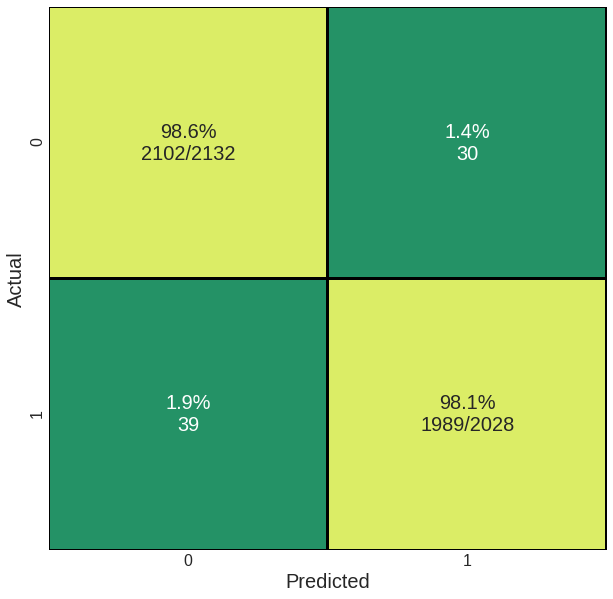

In [ ]:
## train using best parameter
Clf2 = LogisticRegression(C=best_c,max_iter=400)
Clf2.fit(train_features,ytrain)
# predict on validation set
val_pred = Clf2.predict(val_features)
print('The model f1 score on the val set is {:.5f}.'.format(f1_score(yvalid, val_pred)))
print('The model precision on the val set is {:.5f}.'.format(precision_score(yvalid, val_pred)))
print('The model recall on the val set is {:.5f}.'.format(recall_score(yvalid, val_pred)))
cm_analysis(yvalid, val_pred, "abc.jpg",labels=[0,1], ymap={0:'0',1: '1'}, figsize=(10,10))

The score after submitting in kaggle is:


*   Private Score : 0.98351
*   Public Score : 0.98205




In [ ]:
y_pred = Clf2.predict(test_features)
sub = pd.read_csv("/content/drive/MyDrive/submit.csv")
sub["label"]= y_pred
sub.to_csv("submission_log_reg_v2.csv",index=None)

# Random Forest

The model f1 score on the val set is 0.96612.
The model precision on the val set is 0.95518.
The model recall on the val set is 0.97732.


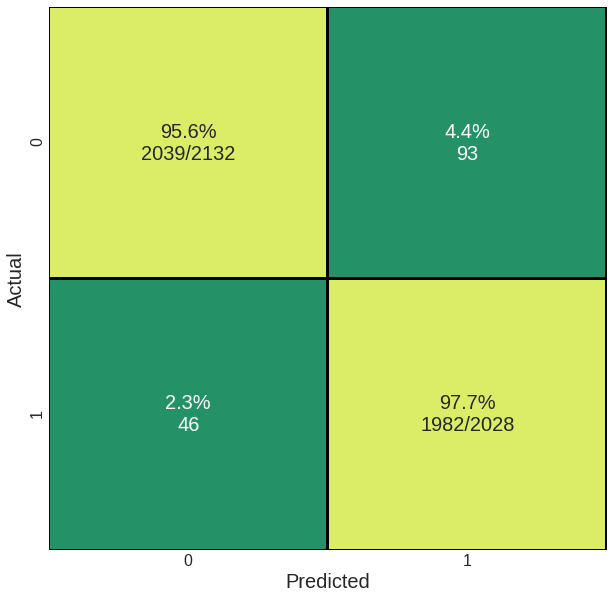

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1,class_weight="balanced",n_estimators=800)
rf.fit(train_features,ytrain)
val_pred_rf = rf.predict(val_features)
print('The model f1 score on the val set is {:.5f}.'.format(f1_score(yvalid, val_pred_rf)))
print('The model precision on the val set is {:.5f}.'.format(precision_score(yvalid, val_pred_rf)))
print('The model recall on the val set is {:.5f}.'.format(recall_score(yvalid, val_pred_rf)))
cm_analysis(yvalid, val_pred_rf, "abc.jpg",labels=[0,1], ymap={0:'0',1: '1'}, figsize=(10,10))

In [ ]:
y_pred = rf.predict(test_features)
sub = pd.read_csv("/content/drive/MyDrive/submit.csv")
sub["label"]= y_pred
sub.to_csv("submission_rf_v2.csv",index=None)

The score after submitting in kaggle is:

* Private Score : 0.96373
* Public Score : 0.97179